In [1]:
import dame_flame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import LabelBinarizer

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STAR_Students = pd.read_spss('STAR_Students.sav')

In [3]:
"""Code to replicate Section 3.2 of dame-flame paper.

Note that this relies on the file Star_Students.sav. To download this file,
please see the original data on the Harvard Dataverse at this link:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/10766

Prints Figure 2 from dame-flame paper to a file with name cate-graph4.png

"""

# Data Cleaning Steps
df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gkfreelunch', 
     'birthmonth', 'gksurban', 'gktreadss', 'gkschid',
     'gkthighdegree', 'birthyear'])]

d = {"WHITE": 1, "BLACK": 0, "ASIAN": 1, "HISPANIC": 0, "OTHER": 0, 
     "NATIVE AMERICAN": 0}
df_trunc['race'] = df_trunc['race'].map(d)

d = {"NON-FREE LUNCH": 0, "FREE LUNCH": 1}
df_trunc['gkfreelunch'] = df_trunc['gkfreelunch'].map(d)

d = {"MALE": 1, "FEMALE": 0}
df_trunc['gender'] = df_trunc['gender'].map(d)
#df_trunc['gktgen'] = df_trunc['gktgen'].map(d)

d = {"WHITE": 1, "BLACK": 0}
#df_trunc['gktrace'] = df_trunc['gktrace'].map(d)

d = {"JANUARY": 0, "FEBRUARY": 1, "MARCH": 2, "APRIL": 3, "MAY": 4, 
     "JUNE": 5, "JULY": 6, "AUGUST": 7, "SEPTEMBER": 8, "OCTOBER": 9, 
     "NOVEMBER": 10, "DECEMBER": 11}
df_trunc['birthmonth'] = df_trunc['birthmonth'].map(d)

d = {1977: 0, 1978: 1, 1979: 2, 1980:3, 1981:4}
df_trunc['birthyear'] = df_trunc['birthyear'].map(d)

d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
df_trunc['gksurban'] = df_trunc['gksurban'].map(d)

d = {"BACHELORS": 0, "MASTERS": 1, "MASTERS + ": 1, "SPECIALIST": 1}
df_trunc['gkthighdegree'] = df_trunc['gkthighdegree'].map(d)

d = {"SMALL CLASS": int(1), "REGULAR CLASS": int(0), 
     "REGULAR + AIDE CLASS": int(0)}
df_trunc['ksmall'] = df_trunc['gkclasstype'].map(d)

df_trunc = df_trunc.dropna().copy()

# Create age variable counting months
df_trunc['age'] = df_trunc['birthyear']*12 + df_trunc['birthmonth']
df_trunc = df_trunc.drop(columns=['birthmonth', 'birthyear', 
                                  'gkclasstype'])
# Bin age into deciles
df_trunc['age'] = pd.qcut(df_trunc['age'], q=10, labels=False)

df_trunc = df_trunc.rename(columns={"ksmall": "treated"}) ## NOTE TO SELF -- COME BACK TO WE SHOULDNT HAVE TO DO THIS

In [4]:
# Do the matching

models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(len(random_seeds)):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=True, verbose=0, adaptive_weights='decisiontree', 
        early_stop_pe=True)
    model_dame.fit(holdout_data=holdout_df, 
                   outcome_column_name='gktreadss')
    model_dame.predict(matching_df)
    models.append(model_dame)



All units have been matched.
All units have been matched.
All units have been matched.
All units have been matched.


In [5]:
ates = []
for i in range(len(models)):
    ate, var = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("Run", i, "ATE:", ate, "& Variance of ATE:", var)
    ates.append(ate)

treated_col treated
Run 0 ATE: 7.4016981430590505 & Variance of ATE: 1.4239210335023478
treated_col treated
Run 1 ATE: 6.192042939318718 & Variance of ATE: 1.2619904513014648
treated_col treated
Run 2 ATE: 5.875096035932277 & Variance of ATE: 1.329790111239645
treated_col treated
Run 3 ATE: 6.80349015148457 & Variance of ATE: 1.3736150187437668


In [6]:
# Generate data for plot
match_dfs = []
for i in models:
    match_dfs.append(i.input_data)

for i in range(4):
    colname = 'cates'
    match_dfs[i][colname] = dame_flame.utils.post_processing.CATE(
        models[i], match_dfs[i].index)

dame_len_groups = []
dame_cate_of_groups = []
log_cates = []

for i in range(4):

    model_dame = models[i]
    groups = list(range(len(model_dame.units_per_group)))

    dame_cate_of_group = []
    log_cate_of_group = []
    dame_len_group = []
    dame_len_treated = []
    maxcate = 0.0
    maxgroupnum = 0
    index = 0

    flame_cate_of_group = []
    flame_len_group = []
    large_groups = []
    for group in model_dame.units_per_group:
        dame_cate_of_group.append(dame_flame.utils.post_processing.CATE(
            model_dame, group[0]))
        dame_len_group.append(len(group))

        # find len of just treated units
        df_mmg = df_trunc.loc[group]
        treated = df_mmg.loc[df_mmg["treated"] == 1]

    dame_len_groups.append(dame_len_group)
    dame_cate_of_groups.append(dame_cate_of_group)



C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

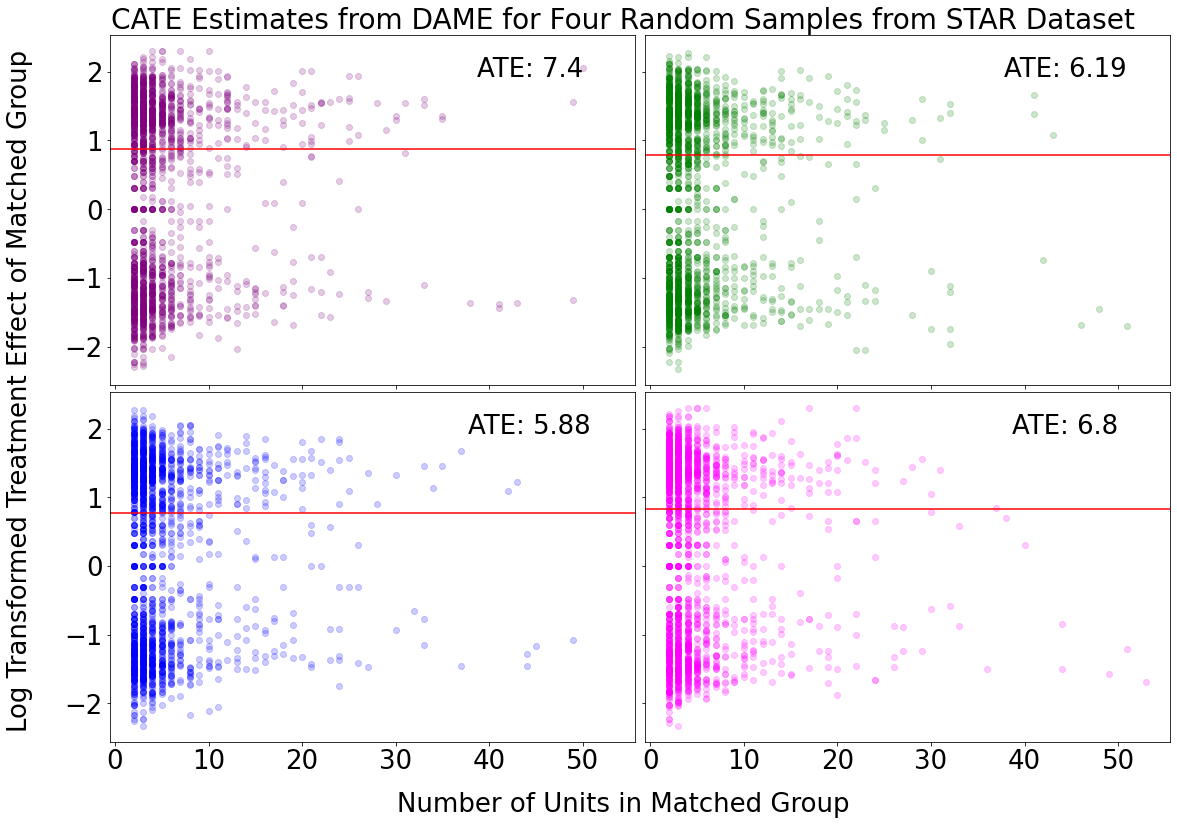

In [9]:
# Plot log scale
# Create the plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Log Transformed Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=np.log10(ates[0]), color='r', linestyle='-')
ax2.axhline(y=np.log10(ates[1]), color='r', linestyle='-')
ax3.axhline(y=np.log10(ates[2]), color='r', linestyle='-')
ax4.axhline(y=np.log10(ates[3]), color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

al=0.2

temp = np.array(dame_cate_of_groups[0])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax1.scatter(dame_len_groups[0], result, color="purple", 
            alpha = al)
ax1.text(0.8, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[1])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax2.scatter(dame_len_groups[1], result, color="green", 
            alpha = al)
ax2.text(0.8, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[2])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax3.scatter(dame_len_groups[2], result, color="blue", 
            alpha = al)
ax3.text(0.8, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[3])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax4.scatter(dame_len_groups[3], result, color="magenta",
            alpha = al)
ax4.text(0.8, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)

plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('cate-graph4.png', dpi = 200)

In [10]:
list_star_covars = []
for modelid in range(len(models)):

    # Pull out the groups with 10 or more units in the matched group
    model = models[modelid]
    large_groups = []
    for group in model.units_per_group:
        if len(group) >= 12.5:
            large_groups.append(group)

    covariates = set(models[modelid].input_data.columns) - set(['gktreadss', 'treated', 'cates'])
    # Which covars did the large group match on?
    star_covars = dict()
    for group in large_groups:
        group_star_covars = []
        matched_df = models[modelid].df_units_and_covars_matched.loc[group]
        for covar in covariates:
            if '*' in matched_df[covar].values:
                group_star_covars.append(covar)
        cate_of_group = models[modelid].input_data.loc[group[0], 'cates']
        star_covars[cate_of_group] = group_star_covars
        
    list_star_covars.append(star_covars)

In [11]:
list_star_covars

[{-44.75: ['gender'],
  3.25: ['gender', 'gkfreelunch', 'race'],
  28.0: ['age', 'gender'],
  -8.333333333333314: ['age', 'gender', 'gkfreelunch'],
  8.0: ['gkthighdegree', 'age', 'gkfreelunch', 'race'],
  -1.0: ['age', 'gender', 'gkfreelunch'],
  10.416666666666686: ['gkthighdegree',
   'age',
   'gender',
   'gkfreelunch',
   'race'],
  32.95588235294116: ['gkthighdegree',
   'gkschid',
   'age',
   'gender',
   'gkfreelunch',
   'race'],
  36.0: ['age', 'gender', 'gkfreelunch', 'race'],
  -13.75: ['gkthighdegree', 'age', 'gender', 'gkfreelunch', 'race'],
  37.0: ['gkthighdegree', 'age', 'gender'],
  -14.5: ['gkthighdegree', 'age', 'gender', 'gkfreelunch'],
  -16.071428571428555: ['gkthighdegree', 'age', 'gkfreelunch'],
  -15.75: ['age', 'gender', 'gkfreelunch'],
  -26.666666666666686: ['age', 'gender', 'gkfreelunch'],
  -12.333333333333314: ['gkthighdegree', 'age', 'gender', 'gkfreelunch'],
  67.5: ['age', 'gender', 'gkfreelunch', 'race'],
  14.666666666666686: ['age', 'gender', 'gk

In [12]:
models[3].input_data.loc[large_groups[0]]

,gender,race,gkschid,gksurban,gkthighdegree,gkfreelunch,gktreadss,treated,age,cates
1124,1,0.0,215533.0,0,1.0,1,437.0,0.0,0,-36.000
2402,1,1.0,215533.0,0,0.0,1,431.0,0.0,0,-41.125
1763,1,1.0,215533.0,0,0.0,0,400.0,0.0,0,-44.400
2407,1,1.0,215533.0,0,0.0,0,468.0,0.0,0,-44.400
2405,1,0.0,215533.0,0,1.0,1,428.0,0.0,0,-36.000
8637,1,1.0,215533.0,0,0.0,0,490.0,0.0,0,-44.400
1628,1,0.0,215533.0,0,0.0,1,395.0,0.0,0,-36.000
2397,1,1.0,215533.0,0,0.0,1,440.0,0.0,0,-41.125
2159,1,1.0,215533.0,0,0.0,0,421.0,0.0,0,-44.400
2002,1,1.0,215533.0,0,0.0,0,400.0,1.0,0,-44.400


In [13]:
list_star_covars

[{-44.75: ['gender'],
  3.25: ['gender', 'gkfreelunch', 'race'],
  28.0: ['age', 'gender'],
  -8.333333333333314: ['age', 'gender', 'gkfreelunch'],
  8.0: ['gkthighdegree', 'age', 'gkfreelunch', 'race'],
  -1.0: ['age', 'gender', 'gkfreelunch'],
  10.416666666666686: ['gkthighdegree',
   'age',
   'gender',
   'gkfreelunch',
   'race'],
  32.95588235294116: ['gkthighdegree',
   'gkschid',
   'age',
   'gender',
   'gkfreelunch',
   'race'],
  36.0: ['age', 'gender', 'gkfreelunch', 'race'],
  -13.75: ['gkthighdegree', 'age', 'gender', 'gkfreelunch', 'race'],
  37.0: ['gkthighdegree', 'age', 'gender'],
  -14.5: ['gkthighdegree', 'age', 'gender', 'gkfreelunch'],
  -16.071428571428555: ['gkthighdegree', 'age', 'gkfreelunch'],
  -15.75: ['age', 'gender', 'gkfreelunch'],
  -26.666666666666686: ['age', 'gender', 'gkfreelunch'],
  -12.333333333333314: ['gkthighdegree', 'age', 'gender', 'gkfreelunch'],
  67.5: ['age', 'gender', 'gkfreelunch', 'race'],
  14.666666666666686: ['age', 'gender', 'gk

In [14]:
## Check the matched group with the most units in each trial -- also which covariates did they use and which units in their MMG?

In [15]:
## Run DAME and FLAME and show why we chose DAME for this dataset. What happens if we run FLAME?
flame_models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_flame = dame_flame.matching.FLAME(
        repeats=False, verbose=3, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1, 
        early_stop_pe=True)
    model_flame.fit(holdout_data=holdout_df, 
                   outcome_column_name='gktreadss')
    result_flame = model_flame.predict(matching_df)
    flame_models.append(model_flame)


Iteration number:  1
	Number of matched groups formed in total:  416
	Unmatched treated units:  710 out of a total of  1230 treated units
	Unmatched control units:  2143 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1249
	Number of matches made so far:  1249
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  416
	Unmatched treated units:  710 out of a total of  1230 treated units
	Unmatched control units:  2143 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  65.80502654662973
	Number of matches made in this iteration:  0
	Number of matches made so far:  1249
	In this iteration, the covariates dropped are:  gksurban
Iteration number:  3
	Number of matched groups formed in total:  436
	Unmatched treated units:  687 out of a total of  1230 treated units
	Unmatched control units:  211

Iteration number:  4
	Number of matched groups formed in total:  642
	Unmatched treated units:  437 out of a total of  1240 treated units
	Unmatched control units:  1792 out of a total of  2862 control units
	Predictive error of covariates chosen this iteration:  177.28968718634997
	Number of matches made in this iteration:  643
	Number of matches made so far:  1873
	In this iteration, the covariates dropped are:  gkthighdegree
Iteration number:  5
	Number of matched groups formed in total:  775
	Unmatched treated units:  288 out of a total of  1240 treated units
	Unmatched control units:  1605 out of a total of  2862 control units
	Predictive error of covariates chosen this iteration:  222.21828184825844
	Number of matches made in this iteration:  979
	Number of matches made so far:  2209
	In this iteration, the covariates dropped are:  gkfreelunch
Iteration number:  6
	Number of matched groups formed in total:  876
	Unmatched treated units:  156 out of a total of  1240 treated units


In [16]:
# whats the var of the ates?
for model in flame_models:
    print(dame_flame.utils.post_processing.var_ATE(matching_object=model))

treated_col treated
(6.787408677082164, 1.724307133331674)
treated_col treated
(6.067927227342548, 1.5256039450910286)
treated_col treated
(4.494057932504718, 1.7821943776192581)
treated_col treated
(5.965720108306847, 1.7246571429495845)
